<font size="6">
 <div class="alert alert-block alert-info"> 
    <b>DLCV - Using a pre-trained CNN model - Example with VGG-16</b>
 </div>
</font>

 _________________

  <font size="4"> Tomás Brandão</font>

  <font size="3"> *tomas.brandao@iscte-iul.pt* </font>

  <font size="3"> March 2025 </font>
  
Tested using Tensorflow 2.19, Keras 3.9 and Python 3.12
 _________________
 
In this example, the VGG-16 CNN model is loaded with pre-trained weights (trained on the IMAGENET dataset) and then it is used for classifying a sample image, returning the 5 most probable classes.   

## Libraries and imports

If the import regarding the pre-trained CNN model generates an error, you can try the following alternatives:

- `from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions`
- `from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions` 

In [36]:
from keras.src.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras import utils
from keras import layers
import numpy as np
from keras.src.applications.mobilenet_v3 import MobileNetV3Small, preprocess_input
import matplotlib.pyplot as plt
import keras

## Loading the pre-trained model and preparing the input image

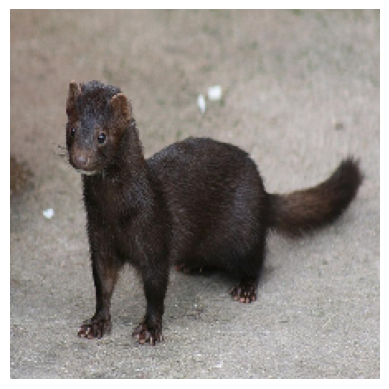

In [ ]:
# Load the VGG-16 model
vgg16Model = VGG16(weights='imagenet', classes=1000)

# a sample image - change it to your own image
IMG_FILE = './data/mink.jpg'

# image size constants - 224x224 is the input image dimension for the VGG-16 CNN
IMG_HEIGHT = 224
IMG_WIDTH = 224

# loads the sample image, and resizes it for the desired dimension (PIL format)
img = utils.load_img(IMG_FILE, target_size=(IMG_HEIGHT, IMG_WIDTH))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

# the sample image requires a few preprocessing steps in order to make it compatible with the VGG-16 model
x = utils.img_to_array(img)       # converts the image from PIL format to numpy array
x = np.expand_dims(x, axis=0)     # creates an additional dimension that represents the batch (we have a single batch containing a single image)
x = preprocess_input(x)           # VGG-16 specific preprocessing (basically a VGG-16 library function that converts the images to BGR and normalizes
                                  # the pixel values by subtracting a predefined offset)

## Predicting the class of the sample image

In [38]:
# get the predictions (returns the output of the 1000 neurons at the VGG-16's output layer)
preds = vgg16Model.predict(x)

# process the predictions using a VGG-16's library function - in this case it was setup to get the 5 most probable classes
decoded_preds = decode_predictions(preds, top=5)[0]

# Shows the classification results
print('Top-5 Class predictions: ')
for class_name, class_description, score in decoded_preds:
    print(class_description, ":", score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Top-5 Class predictions: 
weasel : 1.0
mink : 3.3989758e-12
mongoose : 3.4665866e-25
polecat : 2.51525e-35
beaver : 0.0


In [39]:
# Import MobileNetV3 model

# Load the MobileNetV3Small model with pretrained weights
mobilenet_v3_model = MobileNetV3Small(weights='imagenet')

# Preprocess the image for MobileNetV3
x_mobilenet = preprocess_input(x)

# Get predictions from MobileNetV3
preds_mobilenet = mobilenet_v3_model.predict(x_mobilenet)

# Decode predictions
decoded_preds_mobilenet = decode_predictions(preds_mobilenet, top=5)[0]

# Display the predictions
print('Top-5 Class predictions (MobileNetV3):')
for class_name, class_description, score in decoded_preds_mobilenet:
    print(class_description, ":", score)

/Users/xoutoz/workspace/master/APVC/.venv/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top-5 Class predictions (MobileNetV3):
mink : 0.87583137
weasel : 0.101396546
polecat : 0.0032549088
skunk : 0.001549535
mongoose : 0.0013280052


In [ ]:
# Constantes
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

DATASET_PATH = "./flower_photos"    # ajustar consoante a localização do dataset
SEED = 1245                                 # semente para o split treino/validação
TRAIN_VAL_SPLIT = 0.2                       # fração de imagens para validação
NUM_CLASSES = 5                             # número de classes

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    validation_split=TRAIN_VAL_SPLIT,
    subset="both",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [41]:
# ficheiro onde serão guardados os pesos do "melhor modelo" - ajustar o caminho
BEST_MODEL_PATH = "tmp/best_model.weights.h5"

# callback para guardar o melhor modelo
BEST_MODEL_CHECKPOINT = keras.callbacks.ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [42]:
mobilenet_v3_model = MobileNetV3Small(weights='imagenet', include_top=False)
mobilenet_v3_model.trainable = False

# arquitetura da CNN
flower_model = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal"),
    mobilenet_v3_model,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

# definição do algoritmo de otimização e da função de perda (loss)
flower_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# sumário do modelo
flower_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_6               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     3,612,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,552,565 (17.37 MB)

 Trainable params: 3,613,445 (13.78 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [43]:
EPOCHS = 30
history = flower_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[BEST_MODEL_CHECKPOINT]
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.5422 - loss: 9.2688 - val_accuracy: 0.8025 - val_loss: 4.1260
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7379 - loss: 6.6152 - val_accuracy: 0.8379 - val_loss: 3.2684
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7715 - loss: 5.3737 - val_accuracy: 0.8529 - val_loss: 3.2192
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8065 - loss: 4.2408 - val_accuracy: 0.8542 - val_loss: 3.3069
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8258 - loss: 3.7854 - val_accuracy: 0.8392 - val_loss: 4.0145
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8550 - loss: 3.1959 - val_accuracy: 0.8474 - val_loss: 3.4853
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8547 - loss: 2.7228 - val_accuracy: 0.8638 - val_loss: 3.2861
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8577 - loss: 2.9247 - val_accuracy: 0.8651 -

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


labels = train_ds.class_names

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step
Falhou em 108 amostras num total de 734 imagens de flores
Taxa de acertos: 85.29 %


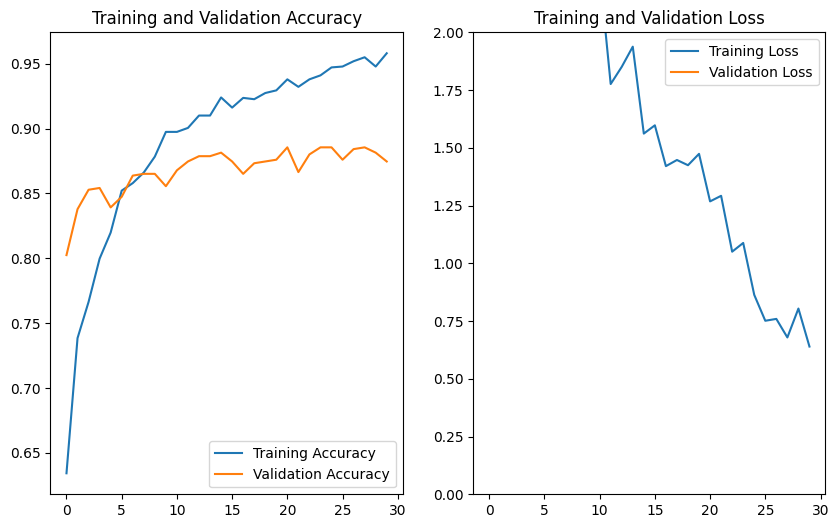

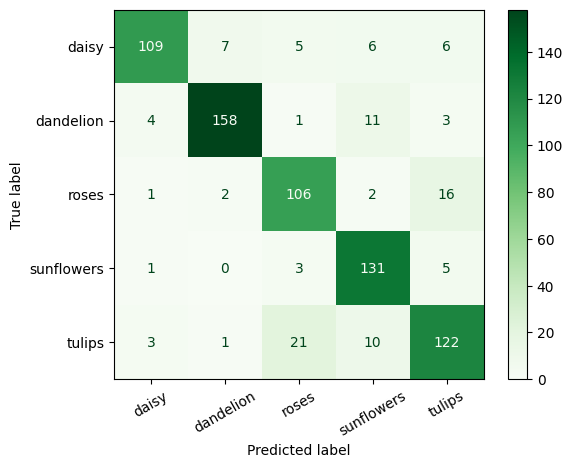

In [45]:
# carregar o melhor modelo encontrado durante o treino
flower_model.load_weights(BEST_MODEL_PATH)

# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

# realizar as predições
y_pred = flower_model.predict(val_ds)
pred_ids = np.argmax(y_pred, axis=1)

# concatena os "targets" do conjunto de validação (pois estavam organizados em batches)
y_true = np.concat([y for x, y in val_ds], axis=0)
true_ids = np.argmax(y_true, axis=1)

n_misses = np.count_nonzero(pred_ids != true_ids)
n_preds = pred_ids.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print("Falhou em {:d} amostras num total de {:d} imagens de flores".format(n_misses, n_preds))
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))


# gerar gráficos e matriz de confusão
cm = confusion_matrix(true_ids, pred_ids)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim(0, 2)
plt.title('Training and Validation Loss')

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=30)
plt.show()

In [46]:
from keras.src.applications.efficientnet_v2 import EfficientNetV2B0

In [49]:
efficient_net__model = EfficientNetV2B0(weights='imagenet', include_top=False)
efficient_net__model.trainable = False

# arquitetura da CNN
flower_model_v2 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # layers.Rescaling(2./255, offset=-1),
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal"),
    efficient_net__model,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

# definição do algoritmo de otimização e da função de perda (loss)
flower_model_v2.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# sumário do modelo
flower_model_v2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_8               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_8 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,948,245 (53.21 MB)

 Trainable params: 8,028,933 (30.63 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [50]:
EPOCHS = 30
history_2 = flower_model_v2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[BEST_MODEL_CHECKPOINT]
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.6692 - loss: 4.0459 - val_accuracy: 0.8678 - val_loss: 2.5617
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.8387 - loss: 3.1280 - val_accuracy: 0.8747 - val_loss: 2.3098
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8561 - loss: 2.8184 - val_accuracy: 0.8883 - val_loss: 2.3573
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8836 - loss: 2.5235 - val_accuracy: 0.8924 - val_loss: 2.2863
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8850 - loss: 1.7814 - val_accuracy: 0.8924 - val_loss: 2.3272
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8940 - loss: 2.1803 - val_accuracy: 0.8896 - val_loss: 2.3071
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9187 - loss: 1.6574 - val_accuracy: 0.9142 - val_loss: 2.2527
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.9180 - loss: 1.6286 - val_accu

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step
Falhou em 593 amostras num total de 734 imagens de flores
Taxa de acertos: 19.21 %


2025-03-20 20:58:16.920594: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


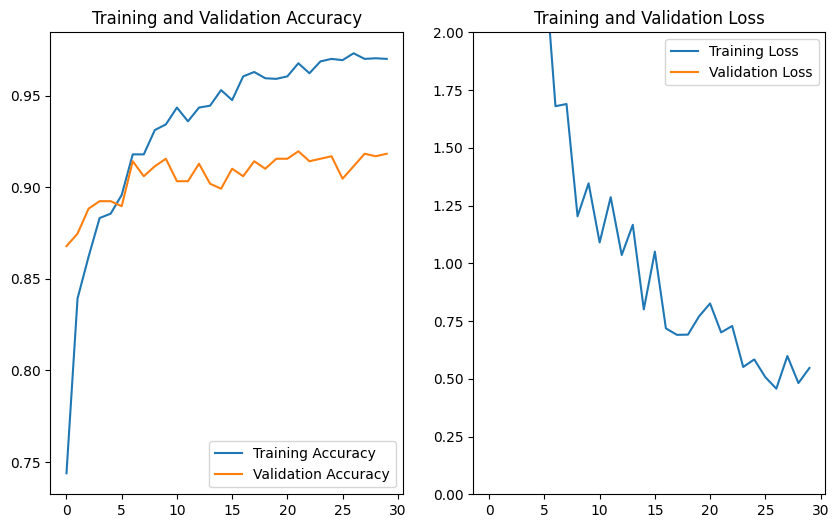

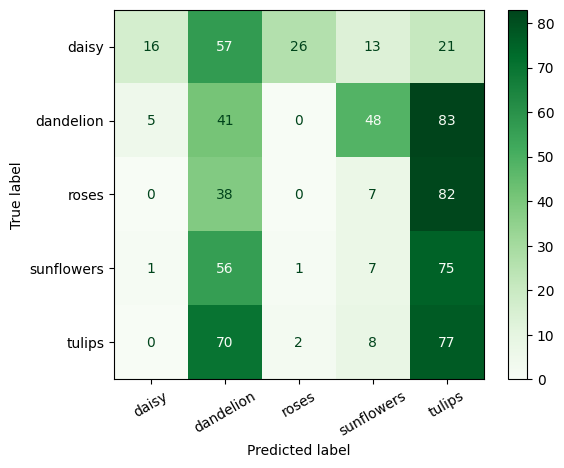

In [51]:
# carregar o melhor modelo encontrado durante o treino
flower_model_v2.load_weights(BEST_MODEL_PATH)

# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

# realizar as predições
y_pred = flower_model_v2.predict(val_ds)
pred_ids = np.argmax(y_pred, axis=1)

# concatena os "targets" do conjunto de validação (pois estavam organizados em batches)
y_true = np.concat([y for x, y in val_ds], axis=0)
true_ids = np.argmax(y_true, axis=1)

n_misses = np.count_nonzero(pred_ids != true_ids)
n_preds = pred_ids.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print("Falhou em {:d} amostras num total de {:d} imagens de flores".format(n_misses, n_preds))
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))


# gerar gráficos e matriz de confusão
cm = confusion_matrix(true_ids, pred_ids)

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim(0, 2)
plt.title('Training and Validation Loss')

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=30)
plt.show()